In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.colors
import pathlib
import tensorflow as tf
import tqdm
import annotation, misc, hyspec_io, image_render, hyspec_cnn, hyspec_ml, preprocess
import skimage.exposure
import sklearn.metrics
import pickle
import skimage.filters.rank
import skimage.morphology

In [3]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Paths
base_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS')

pca_data_model_file = base_dir / 'M_PCA_Model/20210825_OlbergAreaA_PCA_data_and_model.npz'
hyspec_dir = base_dir / '4a_Rad_Georef_SGC'
annotation_dir = base_dir / 'M_Annotation/20210825_Olbergholmen_Annotation_20230228_gray/OlbergAreaS'
example_unet_model = base_dir / 'X_SavedKerasModels/20230504_Unet_Depth5_WeightedAcc/unet_model.epoch114-loss0.000139-acc1.000.hdf5'
# example_unet_model = base_dir / 'X_SavedKerasModels/20230504_Unet_Depth5_WeightedAcc/unet_model.epoch59-loss0.001411-acc0.995.hdf5'
#example_unet_model = base_dir / 'X_SavedKerasModels/20230504_Unet_Depth5_WeightedAcc/unet_model.epoch30-loss0.010816-acc0.959.hdf5'
json_gray = base_dir / 'M_Annotation/20210825_Olbergholmen_Annotation_20230228_gray/label_classes.json'

train_dataset_path = base_dir / '5c_Rad_Georef_SGC_PCA_Tiles/20230503_UnetTraining_SeparateTrainValDatasets/20210825_Olberg_PCA_TrainDataset'
val_dataset_path = base_dir / '5c_Rad_Georef_SGC_PCA_Tiles/20230503_UnetTraining_SeparateTrainValDatasets/20210825_Olberg_PCA_ValDataset'
class_dict_path =  base_dir / '4c_Rad_Georef_SGC_Tiles/tile_classes_merged_NGT.json'
random_forest_save_path = base_dir / 'X_SavedModels_RF_SVM/20210825_Olberg_RandomForest.pkl'


In [5]:
# Parameters
pad_multiple = 32
test_image_numbers = [12,17,24]  # NOTE!! Image 24 part of training data
classes = ['Background', 'Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']

# Instructions for merging / extracting classes
classes_to_merge = [['Zostera marina - dominant','Zostera marina - normal','Zostera marina - sparse'],
                    ['Rockweed','Rockweed with turf algae','Fucus serratus','Saccharina latissima'],
                    ['Turf algae - dominant','Turf algae - normal','Turf algae - sparse','Aegagropila (algae ball)']]
merged_class_names = ['Zostera marina',
                      'Rockweed',
                      'Other algae']
classes_to_extract = ['Sand',
                      'Zostera marina',
                      'Zostera marina with turf algae',
                      'Rockweed',
                      'Other algae']

custom_cmap = matplotlib.colors.ListedColormap(colors=['black','aqua','yellowgreen','lightgreen','brown','violet'])

In [6]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
#for key,value in class_dict.items():
#    print(f'{key}: {value}')

In [7]:
# Load PCA model
with np.load(pca_data_model_file) as npz_files:
    X_mean = npz_files['spectra_mean']
    X_std = npz_files['spectra_std']
    W_pca = npz_files['pca_components']

In [8]:
hyspec_image_paths = [] #[file for file in hyspec_dir.glob('*' + str() '*.hdr')]
annotation_image_paths = []
for im_num in test_image_numbers:
    hyspec_image_paths.append(list(hyspec_dir.glob('*' + str(im_num) + '*.hdr'))[0])
    annotation_image_paths.append(list(annotation_dir.glob('*' + str(im_num) + '*.png'))[0])

In [9]:
# Load datasets 
training_dataset = tf.data.experimental.load(str(train_dataset_path))
validation_dataset = tf.data.experimental.load(str(val_dataset_path))
print(f'Number of 4-tile batches in training dataset: {training_dataset.cardinality()}')
print(f'Number of 4-tile batches in validation dataset: {validation_dataset.cardinality()}')

Number of 4-tile batches in training dataset: 81
Number of 4-tile batches in validation dataset: 35


In [10]:
# Load UNet model 
unet = tf.keras.models.load_model(example_unet_model)

In [11]:
# Run Unet on validation dataset and gather spectra and labels
y_activation_unet = []
y_true = []
X = []
for image_batch,label_batch,weight_batch in validation_dataset.as_numpy_iterator():
    annotated_mask = label_batch>0
    X.append(image_batch[annotated_mask])
    y_true.append(label_batch[annotated_mask])
    
    y_batch_pred = unet.predict(image_batch)
    y_activation_unet.append(y_batch_pred[annotated_mask])

X = np.concatenate(X)
y_true = np.concatenate(y_true)
y_activation_unet = np.concatenate(y_activation_unet)
y_pred_unet = np.argmax(y_activation_unet,axis=1)

1/1 [==============================] - 0s 55ms/step


In [12]:
confusion_matrix_unet = sklearn.metrics.confusion_matrix(y_true,y_pred_unet,normalize='true')

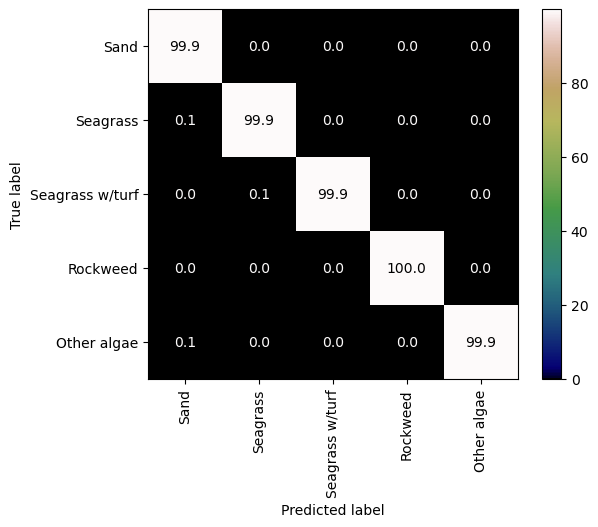

In [13]:
# Show confusion matrix for Unet
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix_unet*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.show()

In [14]:
# Load random forest model
rfc = pickle.load(open(random_forest_save_path,'rb'))

In [15]:
y_pred_rfc = rfc.predict(X)

In [16]:
confusion_matrix_rfc = sklearn.metrics.confusion_matrix(y_true,y_pred_rfc,normalize='true')

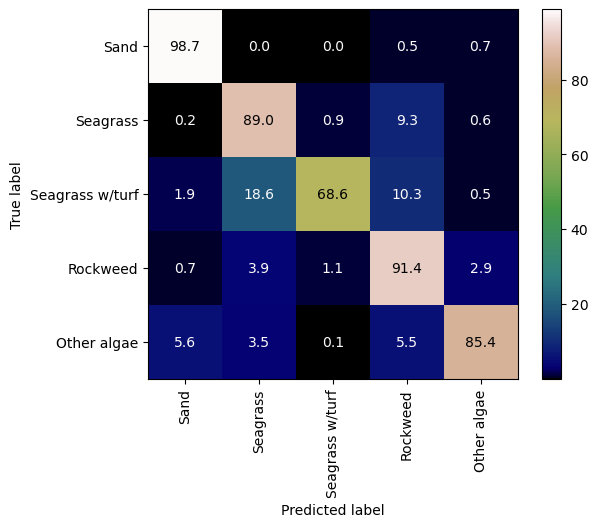

In [17]:
# Show confusion matrix for random forest
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix_rfc*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.show()

In [18]:
# Read images, apply PCA transform, pad images
pca_images = []
label_images = []
rgb_images = []
nonzero_masks = []

for hyspec_image_path, annotation_image_path in tqdm.tqdm(zip(hyspec_image_paths,annotation_image_paths)):
    # Load hyperspectral image
    image,wl,rgb_ind,_ = hyspec_io.load_envi_image(str(hyspec_image_path))
    image = hyspec_cnn.pad_image_to_multiple(image,pad_multiple)
    rgb_image = preprocess.inpaint_missing_pixels(image_render.percentile_stretch(image[:,:,rgb_ind]))
    rgb_images.append(rgb_image)
    
    # Create PCA image
    im_pca = hyspec_ml.pca_transform_image(image,W_pca,X_mean,X_std=X_std)
    im_pca = preprocess.inpaint_missing_pixels(im_pca)
    pca_images.append(im_pca)
    nonzero_masks.append(~np.all(im_pca==0,axis=2,keepdims=False))
    
    # Load annotation image
    label_im = hyspec_cnn.pad_image_to_multiple(skimage.io.imread(annotation_image_path),pad_multiple)
    
    merged_class_dict, merged_class_mask = annotation.merge_classes_with_mask(
        class_dict,label_im,classes_to_merge,merged_class_names)
    filtered_class_dict, filtered_class_mask = annotation.extract_subset(
        merged_class_dict,merged_class_mask,classes_to_extract)
    label_images.append(filtered_class_mask)


0it [00:00, ?it/s]

1it [00:39, 39.56s/it]

2it [01:27, 44.21s/it]

3it [05:03, 101.26s/it]


In [19]:
im_pred_unet = []
im_pred_rfc = []
for pca_im in pca_images:
    im_activation_unet = np.squeeze(unet.predict(np.expand_dims(pca_im,axis=0)))
    im_pred_unet.append(np.argmax(im_activation_unet,axis=2))
    vec_pred_rfc = rfc.predict(np.reshape(pca_im,(-1,pca_im.shape[2])))
    im_pred_rfc.append(np.reshape(vec_pred_rfc,pca_im.shape[0:2]))

1/1 [==============================] - 3s 3s/step



 Image OlbergholmenS_Pika_L_12-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr



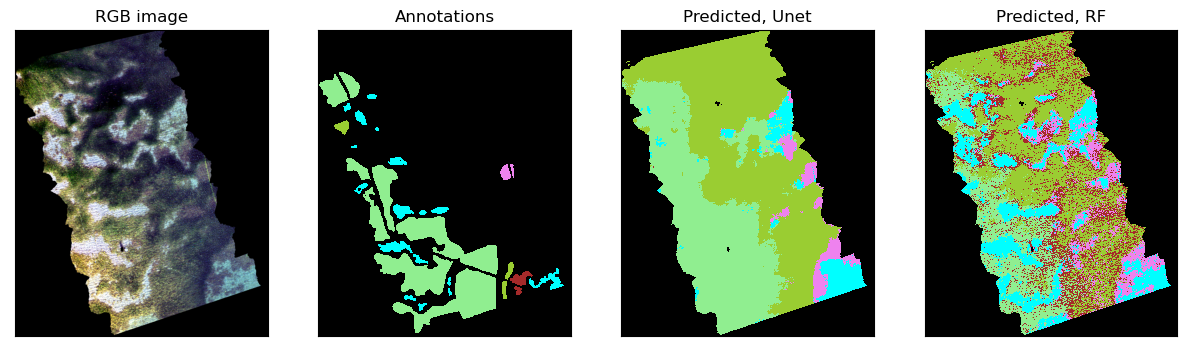


 Image OlbergholmenS_Pika_L_17-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr



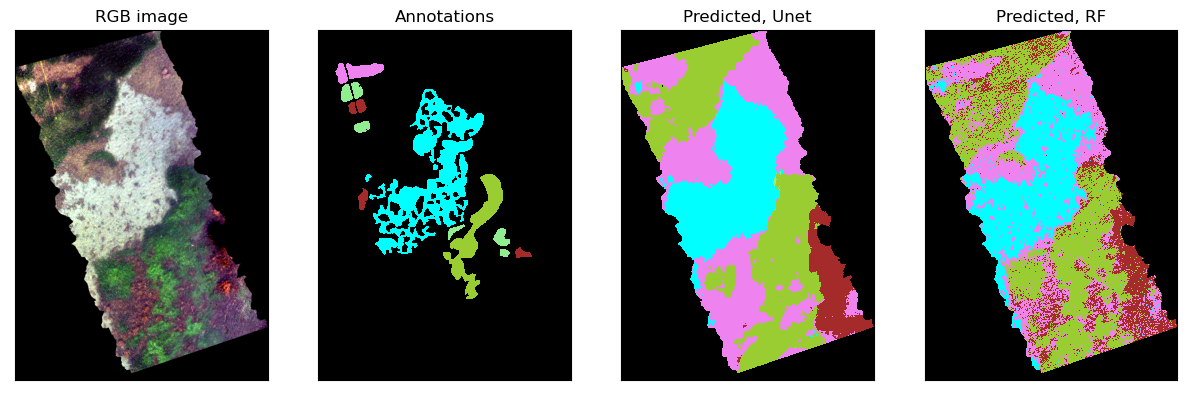


 Image OlbergholmenS_Pika_L_24-Radiance From Raw Data-Georectify Airborne Datacube.bip.hdr



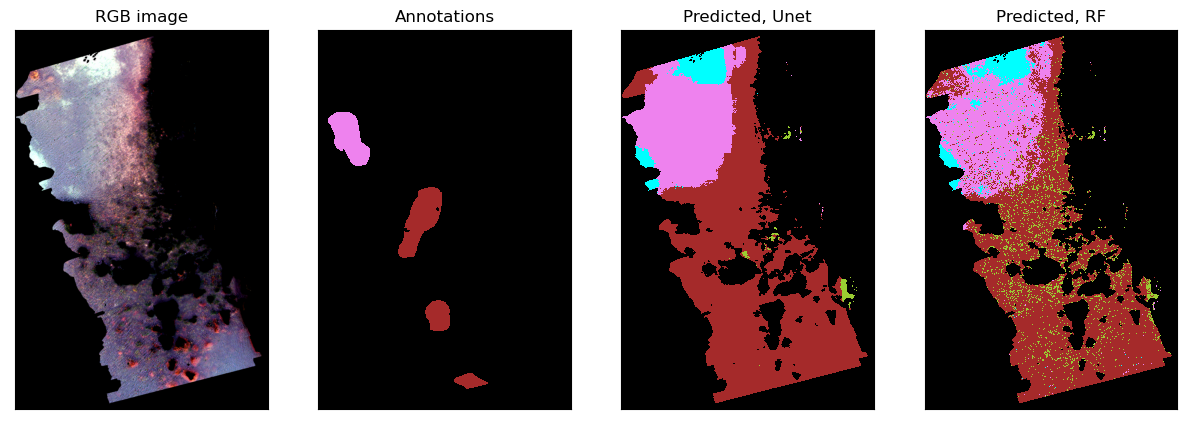

In [20]:
for im_num in range(len(im_pred_unet)):
    print(f'\n Image {hyspec_image_paths[im_num].name}\n')
    fig,(ax0,ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=4,figsize=(15,10))
    # fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
    ax0.imshow(rgb_images[im_num])
    ax0.set_title('RGB image')
    ax1.imshow(label_images[im_num]*nonzero_masks[im_num],vmin=0,vmax=6,cmap=custom_cmap,interpolation='none')
    ax1.set_title('Annotations')
    ax2.imshow(im_pred_unet[im_num]*nonzero_masks[im_num],vmin=0,vmax=6,cmap=custom_cmap,interpolation='none')
    ax2.set_title('Predicted, Unet')
    ax3.imshow(im_pred_rfc[im_num]*nonzero_masks[im_num],vmin=0,vmax=6,cmap=custom_cmap,interpolation='none')
    ax3.set_title('Predicted, RF')
    for ax in (ax0,ax1,ax2,ax3):
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()



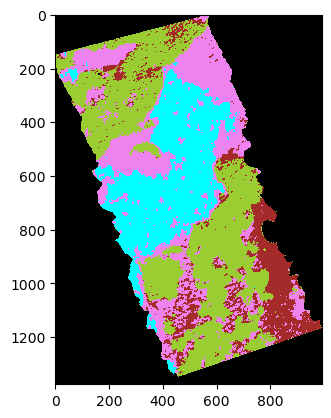

In [21]:
# Test majorify filtering of random forest classification
test_filt_im = skimage.filters.rank.majority(im_pred_rfc[1].astype(np.uint8),skimage.morphology.disk(radius=3))
plt.imshow(test_filt_im*nonzero_masks[1],vmin=0,vmax=6,cmap=custom_cmap,interpolation='none')
plt.show()

In [22]:
# Make confusion matrix based on test images
y_im_true = []
y_im_pred_unet = []
y_im_pred_rfc = []

for im_label_true, im_label_unet, im_label_rfc, nonzero_mask in zip(label_images,im_pred_unet, im_pred_rfc, nonzero_masks):
    annotated_mask = (im_label_true > 0)
    label_mask = nonzero_mask & annotated_mask
    y_im_true.append(im_label_true[label_mask])
    y_im_pred_unet.append(im_label_unet[label_mask])
    y_im_pred_rfc.append(im_label_rfc[label_mask])
    

y_im_true = np.concatenate(y_im_true)
y_im_pred_unet = np.concatenate(y_im_pred_unet)
y_im_pred_rfc = np.concatenate(y_im_pred_rfc)

conf_mat_im_unet = sklearn.metrics.confusion_matrix(y_im_true,y_im_pred_unet,normalize='true')
conf_mat_im_rfc = sklearn.metrics.confusion_matrix(y_im_true,y_im_pred_rfc,normalize='true')


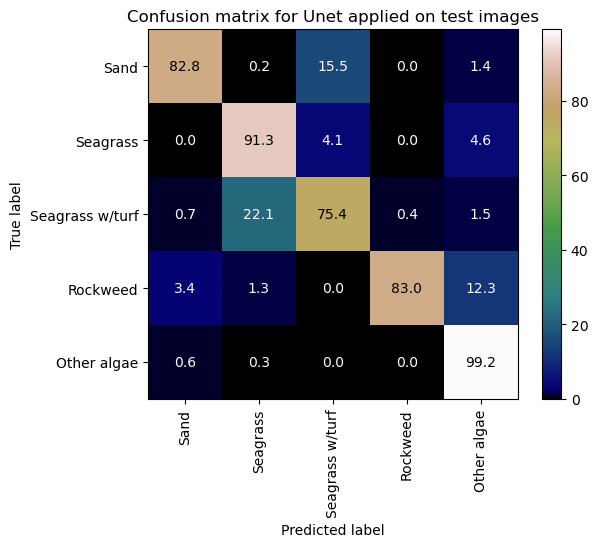

In [23]:
# Show confusion matrix for image
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_mat_im_unet*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix for Unet applied on test images')
plt.show()

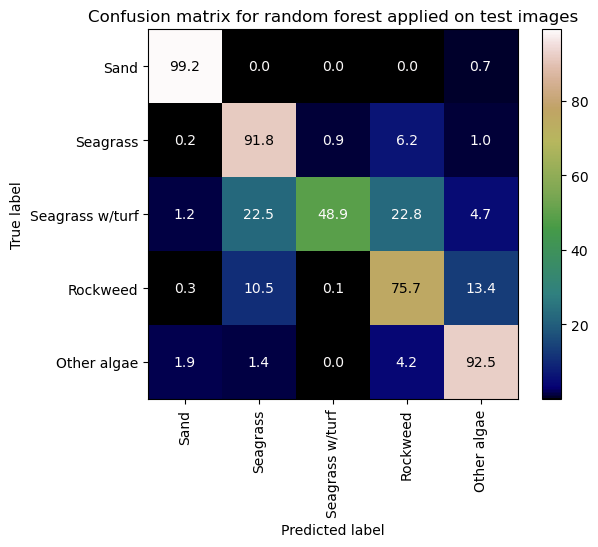

In [24]:
# Show confusion matrix for image
display_labels = ['Sand', 'Seagrass', 'Seagrass w/turf','Rockweed','Other algae']
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_mat_im_rfc*100,display_labels=display_labels)
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.title('Confusion matrix for random forest applied on test images')
plt.show()

In [28]:
# Try visualizing which parts of image are correctly classified
class_result_im = np.zeros_like(im_pred_unet[1],dtype=np.uint8)

In [29]:
class_result_im[im_pred_unet[1] != label_images[1]] = 1
class_result_im[im_pred_unet[1] == label_images[1]] = 2
class_result_im[label_images[1] == 0] = 0

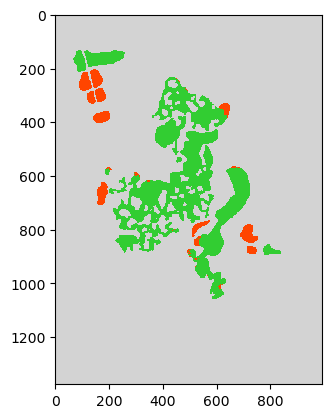

In [43]:
plt.imshow(class_result_im,
           interpolation='none',
           cmap=matplotlib.colors.ListedColormap(colors=['lightgray','orangered','limegreen']))
plt.show()